**All libraries and functions used in this project:**

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## Business Understanding - Diabetes data
The dataset that is used in this kNN model, is that of people above the age of 21 who have been tested for diabetes. Some of these people are diabetic and some were tested not to be diabetic. The goal of the machine learning model that will be built is to determine, with the available data, whether or not a person could possibly be diabetic. By simply testing certain parts of the person's health, we could use the ML-model to quickly determine which person could have diabetes and who could not. This can then be used to further aid the person that has been tested.

## Data Understanding - Loading the data
The data used is that of the "National Institute of Diabetes and Digestive and Kidney Diseases" and has been made available for research purposes. The dataset includes certain values that are used to determine possible diabetes, like bloodpressure, insulin, and BMI. All data originates from atleast 21 year old females of Pima Indian Heritage

The data is in the format of CSV for easy use, it will be imported from a github enviroment.

To load the data into our script, the following code will be used:


In [16]:
URL = "datasets\KNN-diabetes.csv"
rawData = pd.read_csv(URL)

To preview the columns and their data types, the following line of code can be used:


In [17]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Data Preparation - Transforming the data
All data inside the data set is relevant for making predictions. There are no ID's or other columns that have no relation to the health of the patient being tested, this is why we will use every column available. 


In [18]:
#As far as the dataset goes, there are no columns that can not be used for predicting diabetes in other words: nothing has to be eliminated from the dataset.
prepData = rawData
prepData.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


According to the dataset's description, the column 'Outcome' contains the answers we want to predict. A 0 means the patient was tested but does not have diabetes, and a 1 means the patient that was tested did in fact have diabetes. Using the following lines of code, we can quickly determine how many patients were tested positively and negatively. We will also add a line of code to determine a normalized view of these results:


In [19]:
#The column 'Outcome' is what we want to predict, 1 is tested and diagnosed with Diabetes and 0 is tested but not diagnosed with diabetes.
cntOutcome = prepData['Outcome'].value_counts()
propOutcome = prepData['Outcome'].value_counts(normalize=True)

#Amount of Outcomes
cntOutcome

#Normalized amount of Outcomes
propOutcome

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

To be able to use this field in our algorithm we will have to convert the datatype from the 'int64' to 'category'


In [20]:
#Transform the column 'Outcome' to the type Category instead of integer. 
#This is necessary since most models in general cannot use an Integer as a category, they require a column of the type 'Category
categoryType = pd.CategoricalDtype(categories=[0, 1], ordered=False)
prepData['Outcome'] = prepData['Outcome'].astype(categoryType)
prepData['Outcome']

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: category
Categories (2, int64): [0, 1]

To prepare our data for the model we must first normalize it. This will prevent certain broader ranges of data to negatively influence our outcomes. To normalize our data we will create a normalizing function:


In [21]:
def normalize(x):
  return((x - min(x)) / (max(x) - min(x))) #function to normalize

We will then use this function on our data as following:


In [22]:
excluded = ['Outcome'] #This column will be excluded
X = prepData.loc[:, ~prepData.columns.isin(excluded)] #This will fetch the data minus the excluded column and put it into the variable X
X = X.apply(normalize, axis=0) #This will drag the variable X through the normalize function

#To view the results of our normalized data, we use the following code
y = prepData['Outcome']
X[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.226180,0.607510,0.566438,0.207439,0.094326,0.476790,0.168179,0.204015
std,0.198210,0.160666,0.158654,0.161134,0.136222,0.117499,0.141473,0.196004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.497487,0.508197,0.000000,0.000000,0.406855,0.070773,0.050000
50%,0.176471,0.587940,0.590164,0.232323,0.036052,0.476900,0.125747,0.133333
75%,0.352941,0.704774,0.655738,0.323232,0.150414,0.545455,0.234095,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now that our data is normalized, we can start by splitting our set into 2: a test set and a training set. The training set will be used to train our model while the test will be used to see if our model is trained well.


In [23]:
#The test set is 0.3 or 30% of our total dataset, the remainder is used to train our data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

Our data is now prepared and ready to enter the model.

## Modeling - Machine Learning
According to the information in our Data Mining in Python workbook, KNN is an instance-based learning algorithm. It stores all of the training data and makes predictions based on the similarity between the input instance and the stored instances. The prediction is based on the majority class among the K nearest neighbors of the input instance.

KNN in pseudocode: 

In [24]:
# for each instance in the test set:
#     for each instance in the training set:
#         calculate the distance between the two instances
#     sort the distances in ascending order
#     find the K nearest neighbors
#     predict the class based on the majority class among the K 

We only need a few lines of code to train our model using the fit() function. This will train our model to be applied to the test data. It goes as follows:


In [25]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

Now using the predict function, we can use the trained model to predict the test data:


In [26]:
y_pred = knn.predict(X_test)

The predicted and actual outcomes can now be visualized in a table like the diffusion table. For this diffusion table we will use the confusionmatrix functions.


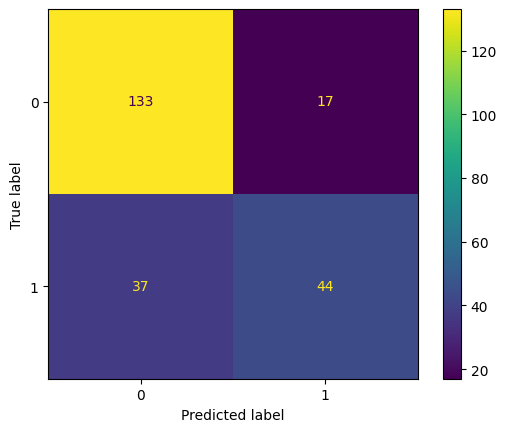

In [27]:
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
cm

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

plt.show()

## Evaluation and Deployment
A simple evaluation of our model can be done with code as well as looking at our generated diffusion table.

The code that we can use will simply give the values for how accurate our model was and how efficient it was:

In [28]:
#Check performance using accuracy - Accuracy score of the model
print(accuracy_score(y_test, y_pred))
#Check performance using roc - Efficiency score of the model
roc_auc_score(y_test, y_pred)

0.7662337662337663


0.7149382716049384

If we take a look at our earlier diffusion table, we can see that the model generated a lot of false negatives which could indicate that our model was not extremely accurate. The code however indicates that our model was about 76% accurate and 70% efficient.

## Reviewer' notes
reviewer adds suggestions for improving the model